# Light 1 Numerical and Data Analysis Answers

In [1]:
%matplotlib inline
import matplotlib
from astropy.table import Table
import requests

## 1. Find and plot optical spectra from SDSS of quasars, galaxies, and stars

There are a number of ways to gather spectra from SDSS. Here, we will first query CasJobs to find good spectra classified in each category. Then we will download their spectra using the SDSS SAS API.

In [2]:
from SciServer import CasJobs
from SciServer import Authentication
from io import StringIO

We will define a convenience function to find different types of objects.

In [3]:
def retrieve_objects(sclass='GALAXY'):
    # We define the columns we want and their 
    columns = ('ra', 'dec', 'z', 'class', 'plate', 'fiberid', 'mjd', 'run2d', 'run1d')
    dtypes= ('f8', 'f8', 'f4', 'S', 'i4', 'i4', 'i4', 'S', 'S')

    # Now define the query
    query = """
SELECT TOP 10 {columns}
FROM specObj 
WHERE class = '{sclass}' and zwarning = 0 and snmedian_r > 8
"""
    query = query.format(columns=', '.join(list(columns)), sclass=sclass)

    # Execute the query (requires internet access)
    responseStream = CasJobs.executeQuery(query, "DR12", format="json")

    # convert result into astropy table
    result = responseStream['Result'][0]
    data = list(map(list, zip(*result['Data'])))
    objects = Table(data, names=columns, dtype=dtypes)
    return(objects)

Let's find some galaxies and show the information.

In [4]:
galaxies = retrieve_objects(sclass='GALAXY')
galaxies.show_in_notebook()

idx,ra,dec,z,class,plate,fiberid,mjd,run2d,run1d
0,215.04742,25.345426,0.0788727,GALAXY,2128,575,53800,26,
1,214.60311,25.114103,0.0165055,GALAXY,2128,577,53800,26,
2,214.79685,25.173384,0.0792593,GALAXY,2128,578,53800,26,
3,215.07301,25.025921,0.0688699,GALAXY,2128,579,53800,26,
4,214.87019,24.678506,0.054722,GALAXY,2128,581,53800,26,
5,214.78653,24.852944,0.165259,GALAXY,2128,582,53800,26,
6,214.72779,24.974805,0.176273,GALAXY,2128,584,53800,26,
7,214.69502,24.937002,0.0180906,GALAXY,2128,585,53800,26,
8,214.89442,24.812244,0.336733,GALAXY,2128,586,53800,26,
9,214.75578,24.943717,0.0178738,GALAXY,2128,587,53800,26,


Now we will download and plot the spectrum of one of the galaxies. This cell will write a file into your local directory called galaxy.fits.

In [5]:
request_template = 'https://dr13.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberid}'
igalaxy = 5
request = request_template.format(plate=galaxies['plate'][igalaxy], fiberid=galaxies['fiberid'][igalaxy], mjd=galaxies['mjd'][igalaxy])
r = requests.get(request)
fp = open('galaxy.fits', 'wb')
fp.write(r.content)
fp.close()

Now we plot it. Note that "loglam" is the base-10 logarithm of the wavelength in Angstroms, and flux is in $10^{-17}$ erg/cm$^2$/s/A.

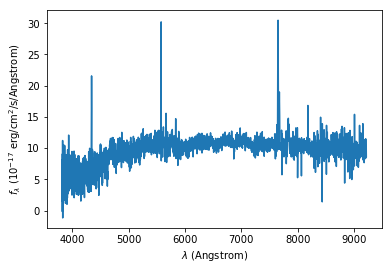

In [6]:
data = fitsio.read('galaxy.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now a quasar.

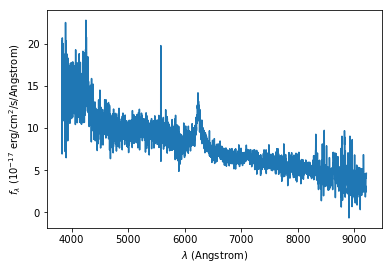

In [7]:
qsos = retrieve_objects(sclass='QSO')
iqso = 5
request = request_template.format(plate=qsos['plate'][iqso], fiberid=qsos['fiberid'][iqso], mjd=qsos['mjd'][iqso])
r = requests.get(request)
fp = open('qso.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('qso.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Finally a star.

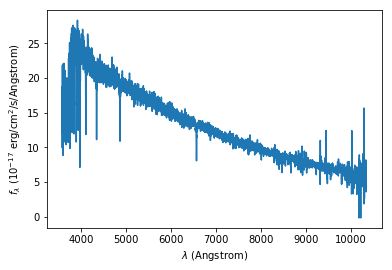

In [8]:
stars = retrieve_objects(sclass='STAR')
istar = 5
request = request_template.format(plate=stars['plate'][istar], fiberid=stars['fiberid'][istar], mjd=stars['mjd'][istar])
r = requests.get(request)
fp = open('star.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('star.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now convert to $f_\nu$.

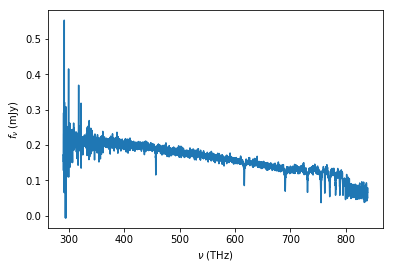

In [9]:
cspeed = 2.99792e+18 # Angstrom / s
nu = cspeed / 10.**data['loglam'] / 1.e+12 # into terahertz
fnu = data['flux'] * 10.**(2.*data['loglam']) / cspeed * (1.e-17 / 1.e-23 * 1.e+3) # into mJy
plt.plot(nu, fnu)
plt.xlabel(r'$\nu$ (THz)')
plt.ylabel(r'$f_\nu$ (mJy)')